# Word Shifts

In [1]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import igraph
#import mpld3

from adjustText import adjust_text

# Style
import seaborn as sns
sns.set_style('whitegrid')

## getting data

In [2]:
# importing results from csv
texts_de = pd.read_csv('texts_de_comb_20200309.csv', index_col=[0])

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
texts_de.head()

,id,created_at,text,lang,score,date_only
0,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.004000,2009-11-22
1,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.340800,2009-11-23
2,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.086533,2009-11-26
3,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01
4,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02


In [4]:
# convert to datetime object
texts_de['date_only'] =  pd.to_datetime(texts_de['date_only'], format='%Y-%m-%d')

---

### defining functions

In [5]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    #vec = CountVectorizer().fit(corpus)
    vec = ws_vectorizer.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

---

### Split: Before/After establishment of coal commission

### comparison to baseline

Set baseline text set as tweets before the establishment of the coal commission, analysis set as tweets after commission's establishment.

In [97]:
tweets_before = texts_de[texts_de['date_only'] < pd.Timestamp(2018,6,6)]
tweets_after = texts_de[texts_de['date_only'] >= pd.Timestamp(2018,6,6)] 

In [98]:
print(len(tweets_before),len(tweets_after))

63402 173478


In [99]:
len(texts_de)

236942

### topic modelling

In [100]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n##############################################\n### Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-5 - 1:-1]]))

In [101]:
tweets_before_tm = tweets_before['text'].tolist()
tweets_after_tm = tweets_after['text'].tolist()

In [64]:
# Stem and vectorize the texts (need to remove @s?)
from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]

vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

tfidf_before = vectorizer.fit_transform(tweets_before_tm)
tfidf_after = vectorizer.fit_transform(tweets_after_tm)

In [65]:
tfidf_feature_names = vectorizer.get_feature_names()

In [71]:
model_before_nmf = NMF(
    n_components=K, 
    random_state=123,
    alpha=0.01, 
    l1_ratio=.91,
    init='nndsvd'
).fit(tfidf_before)

In [72]:
model_after_nmf = NMF(
    n_components=K, 
    random_state=123,
    alpha=0.01, 
    l1_ratio=.91,
    init='nndsvd'
).fit(tfidf_after)

In [73]:
print_top_words(model_before_nmf, tfidf_feature_names, 10)


Topic #0:
genial gesund maria ckemfert kuckumbleibt httpstcohhfgdkqx existenz gegenseit gezielt flagg

Topic #1:
getrag geschaff daifko gespalt houellebeck funktionier erziel ahn drangt beschutz

Topic #2:
aufstand joch betroff hinein getrag gezielt genial bedenkt kuckumbleibt heul

Topic #3:
gezielt flagg gesund ckemfert geschaff httpstcohhfgdkqx gegenseit houellebeck epdost bioenergi

Topic #4:
gesund pappnas neuig anikaschwalb coemission gespalt braunkohledorf beschadigt erpress ran



In [74]:
print_top_words(model_after_nmf, tfidf_feature_names, 10)


Topic #0:
rwe polit nrw unterstutz landesregier massiv interess verstandnis arminlaschet braucht

Topic #1:
kohleausstieg schnell mehr klimaschutz hambibleibt deutschland energiew kohl fridaysforfutur via

Topic #2:
mehr braunkohl arminlaschet davon klimaschad nrw zusamm kohlefrei verlass energietrag

Topic #3:
kohlekommission kohl klimaschutz rwe hambacherforst amp ergebnis hambibleibt fridaysforfutur endegela

Topic #4:
amp wald rett zeig polit konflikt raumung fuhrungsstark dien rweinteress



## word shift

In [102]:
ws_vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=20000,
                             stop_words=stopword_list)

In [103]:
count_before = ws_vectorizer.fit_transform(tweets_before_tm)
count_after = ws_vectorizer.fit_transform(tweets_after_tm)

In [106]:
top_words_before = get_top_n_words(tweets_before_tm)
top_words_after = get_top_n_words(tweets_after_tm)

In [107]:
sample_before = top_words_before[0:1000]
sample_after = top_words_after[0:1000]

In [108]:
top_words_before[0:50]

[('https', 63065),
 ('kohleausstieg', 37548),
 ('kohlefrei', 28493),
 ('kohle', 26259),
 ('klima', 19445),
 ('eisbären', 15296),
 ('merkel', 15217),
 ('schützen', 14586),
 ('kanzlerin', 13932),
 ('stoppen', 12717),
 ('handeln', 11934),
 ('f8smsaqrsf', 10763),
 ('für', 9571),
 ('klimaschutz', 7273),
 ('http', 5767),
 ('via', 4302),
 ('beim', 4272),
 ('endcoal', 3950),
 ('brauchen', 3845),
 ('mehr', 3457),
 ('online', 3300),
 ('climate', 3260),
 ('amp', 3160),
 ('march', 3156),
 ('klimawandel', 3015),
 ('energiewende', 2902),
 ('deutschland', 2870),
 ('keine', 2543),
 ('mache', 2347),
 ('ohne', 2335),
 ('geht', 2215),
 ('müssen', 2074),
 ('ja', 2071),
 ('groko', 1989),
 ('unterzeichnen', 1924),
 ('gibt', 1912),
 ('aufgeben', 1889),
 ('klimaziele', 1873),
 ('stoppt', 1864),
 ('jamaika', 1848),
 ('eine', 1820),
 ('klimaziel', 1775),
 ('schützt', 1753),
 ('macht', 1692),
 ('raus', 1682),
 ('werden', 1681),
 ('campact', 1658),
 ('gegen', 1645),
 ('fordern', 1645),
 ('dafür', 1549)]

In [109]:
top_words_after[:50]

[('co', 100436),
 ('https', 99952),
 ('kohleausstieg', 90277),
 ('rt', 57149),
 ('für', 48321),
 ('kohlekommission', 37319),
 ('kohle', 31331),
 ('rwe', 21781),
 ('eine', 20209),
 ('arminlaschet', 17346),
 ('klimaschutz', 15963),
 ('kohlefrei', 15312),
 ('mehr', 14644),
 ('amp', 14052),
 ('stopptdenwahnsinn', 13437),
 ('werden', 12454),
 ('hambacherforst', 12215),
 ('nrw', 12191),
 ('fridaysforfuture', 12172),
 ('szmwaq9fcf', 12146),
 ('hambibleibt', 11456),
 ('hambacher', 11182),
 ('braucht', 10235),
 ('alle', 10188),
 ('braunkohle', 9669),
 ('forst', 9488),
 ('lösung', 9417),
 ('politische', 9112),
 ('haben', 8653),
 ('deutschland', 8599),
 ('einen', 8339),
 ('klima', 7495),
 ('einer', 7480),
 ('energiewende', 7427),
 ('2038', 7155),
 ('heute', 7138),
 ('wald', 7129),
 ('via', 7085),
 ('gegen', 6951),
 ('über', 6696),
 ('geht', 6597),
 ('klimakrise', 6571),
 ('co2', 6431),
 ('keine', 6376),
 ('habe', 6361),
 ('beim', 6286),
 ('davon', 5912),
 ('fridayforfuture', 5804),
 ('ende__gelae

In [110]:
df_sample_before = pd.DataFrame(sample_before, columns=['word', 'count'])

In [111]:
df_sample_after = pd.DataFrame(sample_after, columns=['word', 'count'])

In [112]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [113]:
word_scores_before = []
for i in df_sample_before.index:
    entry = df_sample_before.loc[i]
    doc = nlp(entry['word'])
    for token in doc:
        score = token._.sentiws
    word_scores_before.append(score)

In [114]:
word_scores_after = []
for i in df_sample_after.index:
    entry = df_sample_after.loc[i]
    doc = nlp(entry['word'])
    for token in doc:
        score = token._.sentiws
    word_scores_after.append(score)

In [115]:
df_sample_before['score'] = word_scores_before
df_sample_after['score'] = word_scores_after

In [116]:
df_sample_before_scores = df_sample_before[pd.isnull(df_sample_before['score']) == False]
df_sample_after_scores = df_sample_after[pd.isnull(df_sample_after['score']) == False]

In [117]:
score_product_before = df_sample_before_scores['count']*df_sample_before_scores['score']
score_product_after = df_sample_after_scores['count']*df_sample_after_scores['score']

df_sample_before_scores['score product'] = score_product_before
df_sample_after_scores['score product'] = score_product_after

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [118]:
sum_before = df_sample_before['count'].sum()
sum_before

591499

In [119]:
sum_after = df_sample_after['count'].sum()
sum_after

1953092

In [120]:
df_sample_before_scores =  df_sample_before_scores.rename(columns={"count": "count_before", "score product": "score_prod_bef"})
df_sample_after_scores = df_sample_after_scores.rename(columns={"count": "count_after", "score product": "score_prod_aft"})

In [121]:
df_sample_before_scores['count_before_norm'] = df_sample_before_scores['count_before']/sum_before
df_sample_before_scores['score_prod_bef_norm'] = df_sample_before_scores['count_before_norm']*df_sample_before_scores['score']
df_sample_before_scores

,word,count_before,score,score_prod_bef,count_before_norm,score_prod_bef_norm
36,aufgeben,1889,-0.2098,-396.3122,0.003194,-6.700133e-04
50,rettet,1523,0.0040,6.0920,0.002575,1.029926e-05
62,erreichen,1295,0.0040,5.1800,0.002189,8.757411e-06
81,unmöglich,1014,-0.3559,-360.8826,0.001714,-6.101153e-04
109,retten,744,0.0040,2.9760,0.001258,5.031285e-06
116,neue,656,0.0040,2.6240,0.001109,4.436187e-06
144,ende,502,-0.2088,-104.8176,0.000849,-1.772067e-04
157,möglich,443,0.0040,1.7720,0.000749,2.995779e-06
180,gut,380,0.3716,141.2080,0.000642,2.387291e-04
192,blockade,348,-0.0048,-1.6704,0.000588,-2.824012e-06


In [122]:
df_sample_after_scores['count_after_norm'] = df_sample_after_scores['count_after']/sum_after
df_sample_after_scores['score_prod_aft_norm'] = df_sample_after_scores['count_after_norm']*df_sample_after_scores['score']
df_sample_after_scores

,word,count_after,score,score_prod_aft,count_after_norm,score_prod_aft_norm
26,lösung,9417,0.0040,37.6680,0.004822,1.928634e-05
57,retten,5317,0.0040,21.2680,0.002722,1.088940e-05
58,unterstützung,5271,0.0040,21.0840,0.002699,1.079519e-05
60,interessen,5212,0.0040,20.8480,0.002669,1.067436e-05
67,verständnis,4975,0.0040,19.9000,0.002547,1.018897e-05
83,konflikt,4096,-0.0048,-19.6608,0.002097,-1.006650e-05
86,interesse,3992,0.0040,15.9680,0.002044,8.175754e-06
110,ende,2996,-0.2088,-625.5648,0.001534,-3.202946e-04
127,neue,2514,0.0040,10.0560,0.001287,5.148759e-06
144,gut,2318,0.3716,861.3688,0.001187,4.410283e-04


In [123]:
df_sample_before_scores.sort_values(by=['score_prod_bef_norm'])[:20]

,word,count_before,score,score_prod_bef,count_before_norm,score_prod_bef_norm
36,aufgeben,1889,-0.2098,-396.3122,0.003194,-0.000670
81,unmöglich,1014,-0.3559,-360.8826,0.001714,-0.000610
144,ende,502,-0.2088,-104.8176,0.000849,-0.000177
484,streit,137,-0.6632,-90.8584,0.000232,-0.000154
259,protest,253,-0.3564,-90.1692,0.000428,-0.000152
422,kampf,156,-0.5372,-83.8032,0.000264,-0.000142
400,gefährdet,163,-0.5006,-81.5978,0.000276,-0.000138
365,problem,180,-0.3865,-69.5700,0.000304,-0.000118
903,falsch,71,-0.7618,-54.0878,0.000120,-0.000091
655,fehlt,100,-0.5365,-53.6500,0.000169,-0.000091


In [124]:
df_sample_before_scores.sort_values(by=['score_prod_bef_norm'], ascending=False)[:20]

,word,count_before,score,score_prod_bef,count_before_norm,score_prod_bef_norm
180,gut,380,0.3716,141.2080,0.000642,0.000239
295,wichtig,231,0.3822,88.2882,0.000391,0.000149
282,besser,236,0.3716,87.6976,0.000399,0.000148
303,gute,227,0.3716,84.3532,0.000384,0.000143
489,wichtiger,136,0.3822,51.9792,0.000230,0.000088
527,helfen,127,0.3730,47.3710,0.000215,0.000080
633,sicher,105,0.3733,39.1965,0.000178,0.000066
679,hilft,96,0.3730,35.8080,0.000162,0.000061
198,liebe,336,0.0985,33.0960,0.000568,0.000056
699,erfolg,92,0.3446,31.7032,0.000156,0.000054


In [125]:
df_sample_after_scores.sort_values(by=['score_prod_aft_norm'])[:20]

,word,count_after,score,score_prod_aft,count_after_norm,score_prod_aft_norm
110,ende,2996,-0.2088,-625.5648,0.001534,-0.000320
411,kritik,934,-0.5308,-495.7672,0.000478,-0.000254
613,falsch,628,-0.7618,-478.4104,0.000322,-0.000245
590,streit,655,-0.6632,-434.3960,0.000335,-0.000222
473,gefährdet,802,-0.5006,-401.4812,0.000411,-0.000206
373,zerstörung,1026,-0.3578,-367.1028,0.000525,-0.000188
354,blockieren,1060,-0.3459,-366.6540,0.000543,-0.000188
798,schlecht,468,-0.7706,-360.6408,0.000240,-0.000185
381,protest,998,-0.3564,-355.6872,0.000511,-0.000182
602,kampf,637,-0.5372,-342.1964,0.000326,-0.000175


In [126]:
df_sample_after_scores.sort_values(by=['score_prod_aft_norm'], ascending=False)[:20]

,word,count_after,score,score_prod_aft,count_after_norm,score_prod_aft_norm
144,gut,2318,0.3716,861.3688,0.001187,0.000441
351,besser,1065,0.3716,395.7540,0.000545,0.000203
384,gute,995,0.3716,369.7420,0.000509,0.000189
401,wichtig,949,0.3822,362.7078,0.000486,0.000186
466,möchte,814,0.3450,280.8300,0.000417,0.000144
538,sicher,727,0.3733,271.3891,0.000372,0.000139
161,schnell,2107,0.1169,246.3083,0.001079,0.000126
654,wichtiger,588,0.3822,224.7336,0.000301,0.000115
182,schneller,1913,0.1169,223.6297,0.000979,0.000115
816,hilft,458,0.3730,170.8340,0.000234,0.000087


### finding the differences

In [127]:
df_joined = df_sample_before_scores.merge(df_sample_after_scores, on="word")

In [128]:
df_joined["difference"] = df_joined['score_prod_aft'] - df_joined['score_prod_bef']

In [129]:
df_joined["difference_abs"] = df_joined["difference"].abs()

In [130]:
df_joined["difference_norm"] = df_joined['score_prod_aft_norm'] - df_joined['score_prod_bef_norm']
df_joined["difference_norm_abs"] = df_joined["difference_norm"].abs()

In [131]:
df_joined.sort_values(by='difference_norm_abs', ascending=False)

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
0,aufgeben,1889,-0.2098,-396.3122,0.003194,-6.700133e-04,614,-0.2098,-128.8172,0.000314,-6.595552e-05,267.4950,267.4950,6.040578e-04,6.040578e-04
6,gut,380,0.3716,141.2080,0.000642,2.387291e-04,2318,0.3716,861.3688,0.001187,4.410283e-04,720.1608,720.1608,2.022992e-04,2.022992e-04
50,kritik,90,-0.5308,-47.7720,0.000152,-8.076430e-05,934,-0.5308,-495.7672,0.000478,-2.538371e-04,-447.9952,447.9952,-1.730728e-04,1.730728e-04
62,falsch,71,-0.7618,-54.0878,0.000120,-9.144191e-05,628,-0.7618,-478.4104,0.000322,-2.449503e-04,-424.3226,424.3226,-1.535084e-04,1.535084e-04
4,ende,502,-0.2088,-104.8176,0.000849,-1.772067e-04,2996,-0.2088,-625.5648,0.001534,-3.202946e-04,-520.7472,520.7472,-1.430879e-04,1.430879e-04
59,blockieren,78,-0.3459,-26.9802,0.000132,-4.561326e-05,1060,-0.3459,-366.6540,0.000543,-1.877300e-04,-339.6738,339.6738,-1.421168e-04,1.421168e-04
61,möchte,74,0.3450,25.5300,0.000125,4.316153e-05,814,0.3450,280.8300,0.000417,1.437874e-04,255.3000,255.3000,1.006259e-04,1.006259e-04
64,blockiert,70,-0.3459,-24.2130,0.000118,-4.093498e-05,757,-0.3459,-261.8463,0.000388,-1.340676e-04,-237.6333,237.6333,-9.313259e-05,9.313259e-05
51,sorgen,89,-0.3618,-32.2002,0.000150,-5.443830e-05,730,-0.3618,-264.1140,0.000374,-1.352287e-04,-231.9138,231.9138,-8.079035e-05,8.079035e-05
10,schnell,249,0.1169,29.1081,0.000421,4.921073e-05,2107,0.1169,246.3083,0.001079,1.261120e-04,217.2002,217.2002,7.690125e-05,7.690125e-05


In [132]:
df_joined.sort_values(by='difference_norm')[:15]

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
50,kritik,90,-0.5308,-47.7720,0.000152,-0.000081,934,-0.5308,-495.7672,0.000478,-0.000254,-447.9952,447.9952,-0.000173,0.000173
62,falsch,71,-0.7618,-54.0878,0.000120,-0.000091,628,-0.7618,-478.4104,0.000322,-0.000245,-424.3226,424.3226,-0.000154,0.000154
4,ende,502,-0.2088,-104.8176,0.000849,-0.000177,2996,-0.2088,-625.5648,0.001534,-0.000320,-520.7472,520.7472,-0.000143,0.000143
59,blockieren,78,-0.3459,-26.9802,0.000132,-0.000046,1060,-0.3459,-366.6540,0.000543,-0.000188,-339.6738,339.6738,-0.000142,0.000142
64,blockiert,70,-0.3459,-24.2130,0.000118,-0.000041,757,-0.3459,-261.8463,0.000388,-0.000134,-237.6333,237.6333,-0.000093,0.000093
51,sorgen,89,-0.3618,-32.2002,0.000150,-0.000054,730,-0.3618,-264.1140,0.000374,-0.000135,-231.9138,231.9138,-0.000081,0.000081
53,zerstört,83,-0.5131,-42.5873,0.000140,-0.000072,546,-0.5131,-280.1526,0.000280,-0.000143,-237.5653,237.5653,-0.000071,0.000071
30,streit,137,-0.6632,-90.8584,0.000232,-0.000154,655,-0.6632,-434.3960,0.000335,-0.000222,-343.5376,343.5376,-0.000069,0.000069
47,kritisiert,95,-0.3466,-32.9270,0.000161,-0.000056,701,-0.3466,-242.9666,0.000359,-0.000124,-210.0396,210.0396,-0.000069,0.000069
25,gefährdet,163,-0.5006,-81.5978,0.000276,-0.000138,802,-0.5006,-401.4812,0.000411,-0.000206,-319.8834,319.8834,-0.000068,0.000068


In [133]:
df_joined.sort_values(by='difference_norm', ascending=False)[:15]

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
0,aufgeben,1889,-0.2098,-396.3122,0.003194,-6.700133e-04,614,-0.2098,-128.8172,0.000314,-0.000066,267.4950,267.4950,0.000604,0.000604
6,gut,380,0.3716,141.2080,0.000642,2.387291e-04,2318,0.3716,861.3688,0.001187,0.000441,720.1608,720.1608,0.000202,0.000202
61,möchte,74,0.3450,25.5300,0.000125,4.316153e-05,814,0.3450,280.8300,0.000417,0.000144,255.3000,255.3000,0.000101,0.000101
10,schnell,249,0.1169,29.1081,0.000421,4.921073e-05,2107,0.1169,246.3083,0.001079,0.000126,217.2002,217.2002,0.000077,0.000077
43,sicher,105,0.3733,39.1965,0.000178,6.626638e-05,727,0.3733,271.3891,0.000372,0.000139,232.1926,232.1926,0.000073,0.000073
17,schneller,214,0.1169,25.0166,0.000362,4.229356e-05,1913,0.1169,223.6297,0.000979,0.000115,198.6131,198.6131,0.000072,0.000072
12,besser,236,0.3716,87.6976,0.000399,1.482633e-04,1065,0.3716,395.7540,0.000545,0.000203,308.0564,308.0564,0.000054,0.000054
15,gute,227,0.3716,84.3532,0.000384,1.426092e-04,995,0.3716,369.7420,0.000509,0.000189,285.3888,285.3888,0.000047,0.000047
14,wichtig,231,0.3822,88.2882,0.000391,1.492618e-04,949,0.3822,362.7078,0.000486,0.000186,274.4196,274.4196,0.000036,0.000036
36,nächste,122,0.2267,27.6574,0.000206,4.675815e-05,697,0.2267,158.0099,0.000357,0.000081,130.3525,130.3525,0.000034,0.000034


In [146]:
df_wordshift = df_joined.sort_values(by='difference_norm_abs', ascending=False)[:30]

In [147]:
polarity = []
for i in df_wordshift.index:
    entry = df_wordshift.loc[i]
    if entry['score_x'] > 0:
        word_polarity = "Positive"
    elif entry['score_x'] < 0:
        word_polarity = "Negative"
    polarity.append(word_polarity)

In [148]:
df_wordshift['polarity'] = polarity

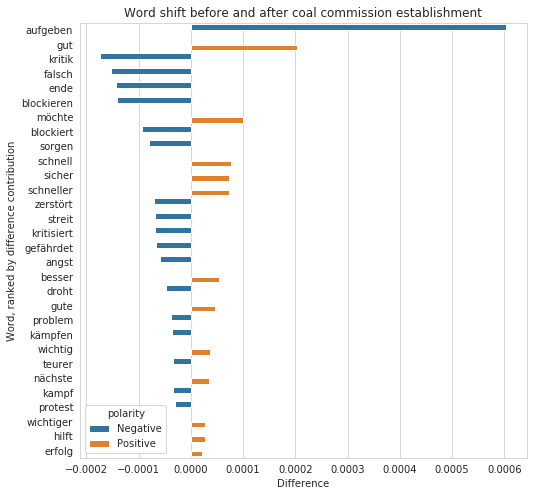

In [149]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='word',
            x='difference_norm',
            hue='polarity',
            data=df_wordshift,
            ax = ax)
ax.set(xlabel="Difference",
       ylabel="Word, ranked by difference contribution", 
       title="Word shift before and after coal commission establishment")
plt.show()
#fig.savefig('plots/wordshift_coalcomm.png', dpi=300)

In [150]:
tweets_before['period'] = "before establishment"
tweets_after['period'] = "after establishment"

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [151]:
tweets_combined = pd.concat([tweets_before, tweets_after], ignore_index=True, sort=False)

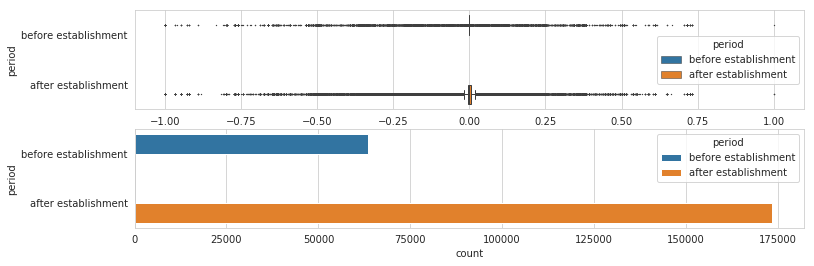

In [152]:
fig, ax = plt.subplots(2,figsize=(12,4))

sns.countplot(y='period', hue='period', data=tweets_combined, ax=ax[1])

sns.boxplot(y='period', x='score', hue='period', data=tweets_combined,
           fliersize=0.5, linewidth=1,
           ax=ax[0]
           )

plt.show()

---

### New Split: Before/After release of coal commission report

Set baseline text set as tweets before the release of the report of the coal commission, comparison set as tweets after commission's establishment.

In [ ]:
# cut off baseline before 2017 or not?

In [153]:
tweets_before = texts_de[texts_de['date_only'] < pd.Timestamp(2019,1,26)]
tweets_after = texts_de[texts_de['date_only'] >= pd.Timestamp(2019,1,26)] 

In [154]:
print(len(tweets_before),len(tweets_after))

124217 112663


In [155]:
len(texts_de)

236942

In [156]:
tweets_before_tm = tweets_before['text'].tolist()
tweets_after_tm = tweets_after['text'].tolist()

# Stem and vectorize the texts (need to remove @s?)
from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]

In [157]:
ws_vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=20000,
                             stop_words=stopword_list)

In [158]:
count_before = ws_vectorizer.fit_transform(tweets_before_tm)
count_after = ws_vectorizer.fit_transform(tweets_after_tm)

In [159]:
top_words_before = get_top_n_words(tweets_before_tm)
top_words_after = get_top_n_words(tweets_after_tm)

In [160]:
sample_before = top_words_before[0:1000]
sample_after = top_words_after[0:1000]

In [161]:
top_words_before[0:50]

[('https', 112297),
 ('kohleausstieg', 62710),
 ('kohlefrei', 43366),
 ('kohle', 38113),
 ('für', 29673),
 ('klima', 22086),
 ('kohlekommission', 17885),
 ('merkel', 15960),
 ('eisbären', 15299),
 ('schützen', 14894),
 ('rwe', 14783),
 ('arminlaschet', 14601),
 ('kanzlerin', 14078),
 ('eine', 13854),
 ('stoppen', 13802),
 ('klimaschutz', 13697),
 ('stopptdenwahnsinn', 13426),
 ('handeln', 12415),
 ('szmwaq9fcf', 12146),
 ('mehr', 12112),
 ('nrw', 10970),
 ('f8smsaqrsf', 10763),
 ('amp', 10524),
 ('braucht', 9832),
 ('hambacher', 9599),
 ('rt', 9283),
 ('hambacherforst', 8991),
 ('politische', 8977),
 ('lösung', 8973),
 ('forst', 8762),
 ('braunkohle', 8612),
 ('via', 7556),
 ('alle', 7418),
 ('hambibleibt', 6495),
 ('davon', 6094),
 ('beim', 6078),
 ('endcoal', 5989),
 ('deutschland', 5940),
 ('wald', 5878),
 ('einer', 5815),
 ('http', 5788),
 ('habe', 5763),
 ('klimaschädlichsten', 5571),
 ('retten', 5513),
 ('energiewende', 5341),
 ('klimawandel', 5219),
 ('landesregierung', 5213),
 

In [162]:
top_words_after[:50]

[('kohleausstieg', 65115),
 ('co', 51017),
 ('https', 50720),
 ('rt', 48636),
 ('für', 28219),
 ('kohlekommission', 20808),
 ('kohle', 19477),
 ('fridaysforfuture', 10161),
 ('klimaschutz', 9539),
 ('werden', 9125),
 ('eine', 8175),
 ('rwe', 7785),
 ('2038', 6878),
 ('amp', 6688),
 ('haben', 6465),
 ('mehr', 5989),
 ('deutschland', 5529),
 ('einen', 5383),
 ('klimakrise', 5248),
 ('co2', 5237),
 ('hambibleibt', 5217),
 ('fridayforfuture', 5093),
 ('energiewende', 4988),
 ('klima', 4854),
 ('gegen', 4729),
 ('heute', 4575),
 ('2030', 4502),
 ('ende__gelaende', 4497),
 ('beim', 4480),
 ('geht', 4422),
 ('cdu', 4351),
 ('schon', 4189),
 ('über', 4087),
 ('keine', 4059),
 ('bundesregierung', 3983),
 ('endegelaende', 3877),
 ('via', 3831),
 ('hambacherforst', 3660),
 ('alle', 3547),
 ('ja', 3392),
 ('weiter', 3383),
 ('mal', 3374),
 ('arminlaschet', 3196),
 ('peteraltmaier', 3138),
 ('einem', 3095),
 ('müssen', 3072),
 ('immer', 3039),
 ('menschen', 2949),
 ('klimawandel', 2900),
 ('gibt', 

In [163]:
df_sample_before = pd.DataFrame(sample_before, columns=['word', 'count'])

In [164]:
df_sample_after = pd.DataFrame(sample_after, columns=['word', 'count'])

In [165]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [166]:
word_scores_before = []
for i in df_sample_before.index:
    entry = df_sample_before.loc[i]
    doc = nlp(entry['word'])
    for token in doc:
        score = token._.sentiws
    word_scores_before.append(score)

In [167]:
word_scores_after = []
for i in df_sample_after.index:
    entry = df_sample_after.loc[i]
    doc = nlp(entry['word'])
    for token in doc:
        score = token._.sentiws
    word_scores_after.append(score)

In [168]:
df_sample_before['score'] = word_scores_before
df_sample_after['score'] = word_scores_after

In [169]:
df_sample_before_scores = df_sample_before[pd.isnull(df_sample_before['score']) == False]
df_sample_after_scores = df_sample_after[pd.isnull(df_sample_after['score']) == False]

In [170]:
score_product_before = df_sample_before_scores['count']*df_sample_before_scores['score']
score_product_after = df_sample_after_scores['count']*df_sample_after_scores['score']

df_sample_before_scores['score product'] = score_product_before
df_sample_after_scores['score product'] = score_product_after

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [171]:
sum_before = df_sample_before['count'].sum()
sum_before

1364081

In [172]:
sum_after = df_sample_after['count'].sum()
sum_after

1147022

In [173]:
df_sample_before_scores =  df_sample_before_scores.rename(columns={"count": "count_before", "score product": "score_prod_bef"})
df_sample_after_scores = df_sample_after_scores.rename(columns={"count": "count_after", "score product": "score_prod_aft"})

In [174]:
df_sample_before_scores['count_before_norm'] = df_sample_before_scores['count_before']/sum_before
df_sample_before_scores['score_prod_bef_norm'] = df_sample_before_scores['count_before_norm']*df_sample_before_scores['score']

In [175]:
df_sample_after_scores['count_after_norm'] = df_sample_after_scores['count_after']/sum_after
df_sample_after_scores['score_prod_aft_norm'] = df_sample_after_scores['count_after_norm']*df_sample_after_scores['score']

In [176]:
df_sample_before_scores.sort_values(by=['score_prod_bef_norm'])[:20]

,word,count_before,score,score_prod_bef,count_before_norm,score_prod_bef_norm
96,aufgeben,2461,-0.2098,-516.3178,0.001804,-0.000379
309,streit,612,-0.6632,-405.8784,0.000449,-0.000298
201,unmöglich,1049,-0.3559,-373.3391,0.000769,-0.000274
149,ende,1576,-0.2088,-329.0688,0.001155,-0.000241
242,blockieren,813,-0.3459,-281.2167,0.000596,-0.000206
354,kampf,513,-0.5372,-275.5836,0.000376,-0.000202
259,protest,735,-0.3564,-261.9540,0.000539,-0.000192
502,vernichten,361,-0.4902,-176.9622,0.000265,-0.000130
549,gefährdet,325,-0.5006,-162.6950,0.000238,-0.000119
469,problem,387,-0.3865,-149.5755,0.000284,-0.000110


In [177]:
df_sample_before_scores.sort_values(by=['score_prod_bef_norm'], ascending=False)[:20]

,word,count_before,score,score_prod_bef,count_before_norm,score_prod_bef_norm
222,gut,964,0.3716,358.2224,0.000707,0.000263
332,wichtig,566,0.3822,216.3252,0.000415,0.000159
339,gute,551,0.3716,204.7516,0.000404,0.000150
357,besser,507,0.3716,188.4012,0.000372,0.000138
164,schneller,1370,0.1169,160.1530,0.001004,0.000117
530,wichtiger,340,0.3822,129.9480,0.000249,0.000095
198,schnell,1065,0.1169,124.4985,0.000781,0.000091
587,sicher,304,0.3733,113.4832,0.000223,0.000083
767,helfen,230,0.3730,85.7900,0.000169,0.000063
796,hilft,222,0.3730,82.8060,0.000163,0.000061


In [178]:
df_sample_after_scores.sort_values(by=['score_prod_aft_norm'])[:20]

,word,count_after,score,score_prod_aft,count_after_norm,score_prod_aft_norm
291,kritik,814,-0.5308,-432.0712,0.000710,-0.000377
86,ende,1922,-0.2088,-401.3136,0.001676,-0.000350
522,falsch,507,-0.7618,-386.2326,0.000442,-0.000337
395,gefährdet,640,-0.5006,-320.3840,0.000558,-0.000279
657,schlecht,405,-0.7706,-312.0930,0.000353,-0.000272
271,zerstörung,857,-0.3578,-306.6346,0.000747,-0.000267
603,dumm,445,-0.5901,-262.5945,0.000388,-0.000229
443,problem,583,-0.3865,-225.3295,0.000508,-0.000196
400,blockiert,635,-0.3459,-219.6465,0.000554,-0.000191
421,kritisiert,609,-0.3466,-211.0794,0.000531,-0.000184


In [179]:
df_sample_after_scores.sort_values(by=['score_prod_aft_norm'], ascending=False)[:20]

,word,count_after,score,score_prod_aft,count_after_norm,score_prod_aft_norm
104,gut,1734,0.3716,644.3544,0.001512,0.000562
299,besser,794,0.3716,295.0504,0.000692,0.000257
374,gute,671,0.3716,249.3436,0.000585,0.000217
413,wichtig,614,0.3822,234.6708,0.000535,0.000205
375,möchte,669,0.3450,230.8050,0.000583,0.000201
497,sicher,528,0.3733,197.1024,0.000460,0.000172
165,schnell,1291,0.1169,150.9179,0.001126,0.000132
680,wichtiger,384,0.3822,146.7648,0.000335,0.000128
786,hilft,332,0.3730,123.8360,0.000289,0.000108
823,helfen,320,0.3730,119.3600,0.000279,0.000104


### finding the differences

In [180]:
df_joined = df_sample_before_scores.merge(df_sample_after_scores, on="word")

In [181]:
df_joined["difference"] = df_joined['score_prod_aft'] - df_joined['score_prod_bef']

In [182]:
df_joined["difference_abs"] = df_joined["difference"].abs()

In [183]:
df_joined["difference_norm"] = df_joined['score_prod_aft_norm'] - df_joined['score_prod_bef_norm']
df_joined["difference_norm_abs"] = df_joined["difference_norm"].abs()

In [184]:
df_joined.sort_values(by='difference_norm_abs', ascending=False)

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
9,gut,964,0.3716,358.2224,0.000707,2.626108e-04,1734,0.3716,644.3544,0.001512,5.617629e-04,286.1320,286.1320,2.991521e-04,2.991521e-04
57,kritik,210,-0.5308,-111.4680,0.000154,-8.171655e-05,814,-0.5308,-432.0712,0.000710,-3.766895e-04,-320.6032,320.6032,-2.949730e-04,2.949730e-04
62,falsch,192,-0.7618,-146.2656,0.000141,-1.072265e-04,507,-0.7618,-386.2326,0.000442,-3.367264e-04,-239.9670,239.9670,-2.294999e-04,2.294999e-04
52,zerstörung,225,-0.3578,-80.5050,0.000165,-5.901776e-05,857,-0.3578,-306.6346,0.000747,-2.673311e-04,-226.1296,226.1296,-2.083133e-04,2.083133e-04
35,gefährdet,325,-0.5006,-162.6950,0.000238,-1.192708e-04,640,-0.5006,-320.3840,0.000558,-2.793181e-04,-157.6890,157.6890,-1.600473e-04,1.600473e-04
56,möchte,219,0.3450,75.5550,0.000161,5.538894e-05,669,0.3450,230.8050,0.000583,2.012211e-04,155.2500,155.2500,1.458321e-04,1.458321e-04
61,blockiert,192,-0.3459,-66.4128,0.000141,-4.868684e-05,635,-0.3459,-219.6465,0.000554,-1.914928e-04,-153.2337,153.2337,-1.428060e-04,1.428060e-04
63,kritisiert,187,-0.3466,-64.8142,0.000137,-4.751492e-05,609,-0.3466,-211.0794,0.000531,-1.840238e-04,-146.2652,146.2652,-1.365089e-04,1.365089e-04
23,besser,507,0.3716,188.4012,0.000372,1.381158e-04,794,0.3716,295.0504,0.000692,2.572317e-04,106.6492,106.6492,1.191158e-04,1.191158e-04
3,ende,1576,-0.2088,-329.0688,0.001155,-2.412385e-04,1922,-0.2088,-401.3136,0.001676,-3.498744e-04,-72.2448,72.2448,-1.086359e-04,1.086359e-04


In [185]:
df_joined.sort_values(by='difference_norm')[:15]

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
57,kritik,210,-0.5308,-111.4680,0.000154,-0.000082,814,-0.5308,-432.0712,0.000710,-0.000377,-320.6032,320.6032,-0.000295,0.000295
62,falsch,192,-0.7618,-146.2656,0.000141,-0.000107,507,-0.7618,-386.2326,0.000442,-0.000337,-239.9670,239.9670,-0.000229,0.000229
52,zerstörung,225,-0.3578,-80.5050,0.000165,-0.000059,857,-0.3578,-306.6346,0.000747,-0.000267,-226.1296,226.1296,-0.000208,0.000208
35,gefährdet,325,-0.5006,-162.6950,0.000238,-0.000119,640,-0.5006,-320.3840,0.000558,-0.000279,-157.6890,157.6890,-0.000160,0.000160
61,blockiert,192,-0.3459,-66.4128,0.000141,-0.000049,635,-0.3459,-219.6465,0.000554,-0.000191,-153.2337,153.2337,-0.000143,0.000143
63,kritisiert,187,-0.3466,-64.8142,0.000137,-0.000048,609,-0.3466,-211.0794,0.000531,-0.000184,-146.2652,146.2652,-0.000137,0.000137
3,ende,1576,-0.2088,-329.0688,0.001155,-0.000241,1922,-0.2088,-401.3136,0.001676,-0.000350,-72.2448,72.2448,-0.000109,0.000109
42,sorgen,274,-0.3618,-99.1332,0.000201,-0.000073,545,-0.3618,-197.1810,0.000475,-0.000172,-98.0478,98.0478,-0.000099,0.000099
31,problem,387,-0.3865,-149.5755,0.000284,-0.000110,583,-0.3865,-225.3295,0.000508,-0.000196,-75.7540,75.7540,-0.000087,0.000087
51,angst,225,-0.5140,-115.6500,0.000165,-0.000085,336,-0.5140,-172.7040,0.000293,-0.000151,-57.0540,57.0540,-0.000066,0.000066


In [186]:
df_joined.sort_values(by='difference_norm', ascending=False)[:15]

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
9,gut,964,0.3716,358.2224,0.000707,0.000263,1734,0.3716,644.3544,0.001512,0.000562,286.1320,286.1320,0.000299,0.000299
56,möchte,219,0.3450,75.5550,0.000161,0.000055,669,0.3450,230.8050,0.000583,0.000201,155.2500,155.2500,0.000146,0.000146
23,besser,507,0.3716,188.4012,0.000372,0.000138,794,0.3716,295.0504,0.000692,0.000257,106.6492,106.6492,0.000119,0.000119
11,blockieren,813,-0.3459,-281.2167,0.000596,-0.000206,325,-0.3459,-112.4175,0.000283,-0.000098,168.7992,168.7992,0.000108,0.000108
38,sicher,304,0.3733,113.4832,0.000223,0.000083,528,0.3733,197.1024,0.000460,0.000172,83.6192,83.6192,0.000089,0.000089
22,kampf,513,-0.5372,-275.5836,0.000376,-0.000202,280,-0.5372,-150.4160,0.000244,-0.000131,125.1676,125.1676,0.000071,0.000071
21,gute,551,0.3716,204.7516,0.000404,0.000150,671,0.3716,249.3436,0.000585,0.000217,44.5920,44.5920,0.000067,0.000067
54,hilft,222,0.3730,82.8060,0.000163,0.000061,332,0.3730,123.8360,0.000289,0.000108,41.0300,41.0300,0.000047,0.000047
20,wichtig,566,0.3822,216.3252,0.000415,0.000159,614,0.3822,234.6708,0.000535,0.000205,18.3456,18.3456,0.000046,0.000046
36,nächste,319,0.2267,72.3173,0.000234,0.000053,500,0.2267,113.3500,0.000436,0.000099,41.0327,41.0327,0.000046,0.000046


In [187]:
df_wordshift = df_joined.sort_values(by='difference_norm_abs', ascending=False)[:35]

In [188]:
polarity = []
for i in df_wordshift.index:
    entry = df_wordshift.loc[i]
    if entry['score_x'] > 0:
        word_polarity = "Positive"
    elif entry['score_x'] < 0:
        word_polarity = "Negative"
    polarity.append(word_polarity)

In [189]:
df_wordshift['polarity'] = polarity

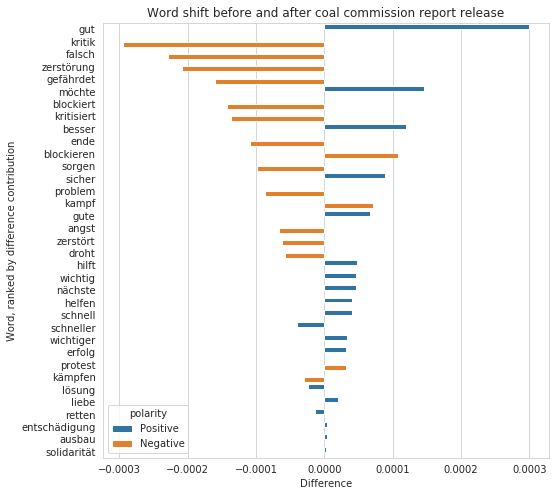

In [190]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='word',
            x='difference_norm',
            hue='polarity',
            data=df_wordshift,
            ax = ax)
ax.set(xlabel="Difference",
       ylabel="Word, ranked by difference contribution", 
       title="Word shift before and after coal commission report release")
plt.show()
#fig.savefig('plots/wordshift_coalcomm_report.png', dpi=300)

In [191]:
tweets_before['period'] = "before report"
tweets_after['period'] = "after report"

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [192]:
tweets_combined = pd.concat([tweets_before, tweets_after], ignore_index=True, sort=False)

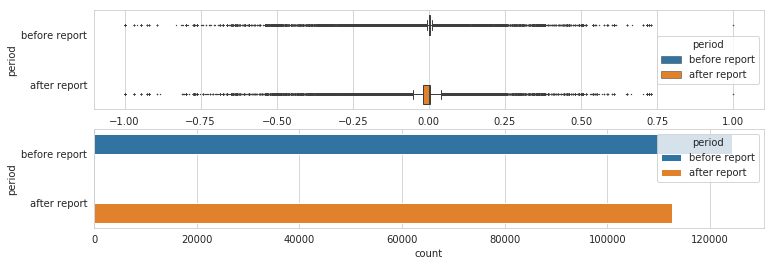

In [193]:
fig, ax = plt.subplots(2,figsize=(12,4))

sns.countplot(y='period', hue='period', data=tweets_combined, ax=ax[1])

sns.boxplot(y='period', x='score', hue='period', data=tweets_combined,
           fliersize=0.5, linewidth=1,
           ax=ax[0]
           )

plt.show()

---

### Comparing coal to climate

In [6]:
texts_climate = pd.read_csv('texts_de_climate_20200311.csv', index_col=[0], lineterminator='\n')

In [7]:
# convert to datetime object
texts_climate['date_only'] =  pd.to_datetime(texts_climate['date_only'], format='%Y-%m-%d')

In [8]:
# compare texts only during the same period, so from 2017-01-01 to 2020-03-01
tweets_before = texts_climate[texts_climate['date_only'] >= pd.Timestamp(2017,1,1)]
tweets_after = texts_de[texts_de['date_only'] >= pd.Timestamp(2017,1,1)] 

In [9]:
print(len(tweets_before),len(tweets_after))

776951 224246


In [10]:
tweets_before_tm = tweets_before['text'].tolist()
tweets_after_tm = tweets_after['text'].tolist()

# Stem and vectorize the texts (need to remove @s?)
from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]

In [11]:
ws_vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=20000,
                             stop_words=stopword_list)

In [12]:
count_before = ws_vectorizer.fit_transform(tweets_before_tm)
count_after = ws_vectorizer.fit_transform(tweets_after_tm)

In [13]:
top_words_before = get_top_n_words(tweets_before_tm)
top_words_after = get_top_n_words(tweets_after_tm)

In [14]:
top_words_before_word = [x[0] for x in top_words_before]
top_words_before_count = [x[1] for x in top_words_before]

In [15]:
sample_before = top_words_before[0:1000]
sample_after = top_words_after[0:1000]

In [16]:
top_words_before[0:50]

[('co', 475639),
 ('https', 473185),
 ('für', 167095),
 ('eine', 75460),
 ('mehr', 61300),
 ('werden', 53642),
 ('haben', 51713),
 ('co2', 50272),
 ('ja', 47032),
 ('schon', 42395),
 ('klimawandel', 41695),
 ('mal', 41555),
 ('via', 40626),
 ('über', 40285),
 ('geht', 35968),
 ('keine', 35550),
 ('erderwärmung', 35159),
 ('gibt', 34483),
 ('immer', 33160),
 ('amp', 32493),
 ('menschen', 31178),
 ('alle', 30646),
 ('einen', 30108),
 ('fürs', 29655),
 ('welt', 29420),
 ('umwelt', 27948),
 ('rt', 27693),
 ('schützen', 27291),
 ('deutschland', 26667),
 ('diese', 25690),
 ('retten', 25678),
 ('klimaschutz', 25554),
 ('gegen', 24980),
 ('können', 24711),
 ('wetter', 24445),
 ('alles', 23720),
 ('gut', 23406),
 ('wieder', 23394),
 ('kohle', 22908),
 ('nichts', 22488),
 ('beim', 22368),
 ('einer', 21772),
 ('machen', 21717),
 ('heute', 21543),
 ('wer', 20355),
 ('tun', 19755),
 ('ohne', 19735),
 ('macht', 19044),
 ('merkel', 18892),
 ('wäre', 18815)]

In [24]:
top_words_before[-50:]

[('ronjajansen', 48),
 ('versorger', 48),
 ('joe_kicrows', 48),
 ('ap', 48),
 ('kinderkriegen', 48),
 ('minen', 48),
 ('mischwald', 48),
 ('anpassungsmaßnahmen', 48),
 ('verroht', 48),
 ('jeffbezos', 48),
 ('plätzen', 48),
 ('mülheim', 48),
 ('scott', 48),
 ('vogelschiss', 48),
 ('maassen', 48),
 ('kd', 48),
 ('antimyon106', 48),
 ('3er', 48),
 ('erleiden', 48),
 ('el_escuincle', 48),
 ('zz', 48),
 ('eifel', 48),
 ('luftmassen', 48),
 ('energieeffiziente', 48),
 ('unbegreiflich', 48),
 ('wahlprogramme', 48),
 ('weißes', 48),
 ('mülleimer', 48),
 ('energieverschwendung', 48),
 ('faharms', 48),
 ('zusammenfassen', 48),
 ('löblich', 48),
 ('christopher', 48),
 ('artikel11', 48),
 ('stettlerroger', 48),
 ('käsesoße', 48),
 ('erfundenen', 48),
 ('nachrechnen', 48),
 ('älteste', 48),
 ('verbergen', 48),
 ('polar', 48),
 ('ltw19', 48),
 ('jahreswechsel', 48),
 ('erschütternd', 48),
 ('angeles', 48),
 ('1969', 48),
 ('climatejusticenow', 48),
 ('diskrepanz', 48),
 ('pochen', 48),
 ('bessert', 

In [18]:
top_words_after[:50]

[('co', 157850),
 ('https', 157259),
 ('kohleausstieg', 119758),
 ('rt', 57505),
 ('für', 55255),
 ('kohle', 52534),
 ('kohlefrei', 43684),
 ('kohlekommission', 38690),
 ('klima', 25316),
 ('rwe', 22260),
 ('eine', 21773),
 ('klimaschutz', 21515),
 ('arminlaschet', 17779),
 ('mehr', 17697),
 ('merkel', 16656),
 ('amp', 16649),
 ('eisbären', 15308),
 ('schützen', 15014),
 ('kanzlerin', 14203),
 ('stoppen', 14095),
 ('werden', 13848),
 ('stopptdenwahnsinn', 13437),
 ('handeln', 13170),
 ('nrw', 12637),
 ('hambacherforst', 12596),
 ('fridaysforfuture', 12172),
 ('szmwaq9fcf', 12146),
 ('hambibleibt', 11703),
 ('hambacher', 11325),
 ('deutschland', 10996),
 ('alle', 10853),
 ('f8smsaqrsf', 10763),
 ('braucht', 10648),
 ('braunkohle', 10496),
 ('via', 10445),
 ('beim', 10289),
 ('haben', 9689),
 ('forst', 9567),
 ('lösung', 9462),
 ('einen', 9349),
 ('politische', 9214),
 ('energiewende', 9032),
 ('keine', 8604),
 ('geht', 8511),
 ('klimakrise', 8029),
 ('gegen', 7828),
 ('einer', 7824),
 (

In [25]:
top_words_after[-50:]

[('132xenon54', 8),
 ('klimawahl2020', 8),
 ('energiegeschichte', 8),
 ('doltschevita', 8),
 ('1150', 8),
 ('j3uts9eice', 8),
 ('timeforaction', 8),
 ('betriebsratsvorsitzenden', 8),
 ('kommissionspräsidentin', 8),
 ('babiš', 8),
 ('belchatów', 8),
 ('ausgleichsmechanismen', 8),
 ('rabatz', 8),
 ('stilllegungsplan', 8),
 ('melanchthon', 8),
 ('insellösung', 8),
 ('ungemütliche', 8),
 ('xxem', 8),
 ('toppt', 8),
 ('yyxm4mwwdf', 8),
 ('derspiegelich', 8),
 ('pres', 8),
 ('hoffmannforest', 8),
 ('lnw', 8),
 ('vikingrohan', 8),
 ('icon', 8),
 ('hambiinsel', 8),
 ('his', 8),
 ('betro', 8),
 ('interessengeleitet', 8),
 ('euwid', 8),
 ('frühstart', 8),
 ('energiefunks', 8),
 ('energiefunk', 8),
 ('dab', 8),
 ('hopefully', 8),
 ('kerstinandrea', 8),
 ('gesetzentwü', 8),
 ('schmalen', 8),
 ('stimmungsla', 8),
 ('venünftig', 8),
 ('verschnarcht', 8),
 ('wannwennnichtwir', 8),
 ('xrmainz', 8),
 ('stopinthenameo', 8),
 ('nichtöf', 8),
 ('xryouthh', 8),
 ('waldschützerin', 8),
 ('frbt0qjj', 8),
 ('

In [26]:
df_sample_before = pd.DataFrame(sample_before, columns=['word', 'count'])

In [27]:
df_sample_after = pd.DataFrame(sample_after, columns=['word', 'count'])

In [28]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [29]:
word_scores_before = []
for i in df_sample_before.index:
    entry = df_sample_before.loc[i]
    doc = nlp(entry['word'])
    for token in doc:
        score = token._.sentiws
    word_scores_before.append(score)

In [30]:
word_scores_after = []
for i in df_sample_after.index:
    entry = df_sample_after.loc[i]
    doc = nlp(entry['word'])
    for token in doc:
        score = token._.sentiws
    word_scores_after.append(score)

In [31]:
df_sample_before['score'] = word_scores_before
df_sample_after['score'] = word_scores_after

In [32]:
df_sample_before_scores = df_sample_before[pd.isnull(df_sample_before['score']) == False]
df_sample_after_scores = df_sample_after[pd.isnull(df_sample_after['score']) == False]

In [33]:
score_product_before = df_sample_before_scores['count']*df_sample_before_scores['score']
score_product_after = df_sample_after_scores['count']*df_sample_after_scores['score']

df_sample_before_scores['score product'] = score_product_before
df_sample_after_scores['score product'] = score_product_after

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [34]:
sum_before = df_sample_before['count'].sum()
sum_before

6651414

In [35]:
sum_after = df_sample_after['count'].sum()
sum_after

2487817

In [36]:
df_sample_before_scores =  df_sample_before_scores.rename(columns={"count": "count_before", "score product": "score_prod_bef"})
df_sample_after_scores = df_sample_after_scores.rename(columns={"count": "count_after", "score product": "score_prod_aft"})

In [37]:
df_sample_before_scores['count_before_norm'] = df_sample_before_scores['count_before']/sum_before
df_sample_before_scores['score_prod_bef_norm'] = df_sample_before_scores['count_before_norm']*df_sample_before_scores['score']

In [38]:
df_sample_after_scores['count_after_norm'] = df_sample_after_scores['count_after']/sum_after
df_sample_after_scores['score_prod_aft_norm'] = df_sample_after_scores['count_after_norm']*df_sample_after_scores['score']

In [39]:
df_sample_before_scores.sort_values(by=['score_prod_bef_norm'])[:20]

,word,count_before,score,score_prod_bef,count_before_norm,score_prod_bef_norm
271,schlecht,5133,-0.7706,-3955.4898,0.000772,-0.000595
284,falsch,4971,-0.7618,-3786.9078,0.000747,-0.000569
171,angst,7342,-0.5140,-3773.7880,0.001104,-0.000567
134,problem,8874,-0.3865,-3429.8010,0.001334,-0.000516
814,gefahr,2068,-1.0000,-2068.0000,0.000311,-0.000311
453,kampf,3504,-0.5372,-1882.3488,0.000527,-0.000283
432,zerstört,3651,-0.5131,-1873.3281,0.000549,-0.000282
327,probleme,4519,-0.3865,-1746.5935,0.000679,-0.000263
573,dumm,2845,-0.5901,-1678.8345,0.000428,-0.000252
524,schaden,3071,-0.5299,-1627.3229,0.000462,-0.000245


In [40]:
df_sample_before_scores.sort_values(by=['score_prod_bef_norm'], ascending=False)[:20]

,word,count_before,score,score_prod_bef,count_before_norm,score_prod_bef_norm
36,gut,23406,0.3716,8697.6696,0.003519,0.001308
96,besser,11582,0.3716,4303.8712,0.001741,0.000647
186,wichtig,6710,0.3822,2564.5620,0.001009,0.000386
210,gute,6264,0.3716,2327.7024,0.000942,0.000350
216,sicher,6204,0.3733,2315.9532,0.000933,0.000348
277,hilft,5023,0.3730,1873.5790,0.000755,0.000282
600,besonders,2774,0.5391,1495.4634,0.000417,0.000225
413,helfen,3773,0.3730,1407.3290,0.000567,0.000212
482,wichtiger,3299,0.3822,1260.8778,0.000496,0.000190
471,möchte,3388,0.3450,1168.8600,0.000509,0.000176


In [41]:
df_sample_after_scores.sort_values(by=['score_prod_aft_norm'])[:20]

,word,count_after,score,score_prod_aft,count_after_norm,score_prod_aft_norm
125,ende,3361,-0.2088,-701.7768,0.001351,-0.000282
456,kritik,991,-0.5308,-526.0228,0.000398,-0.000211
173,aufgeben,2502,-0.2098,-524.9196,0.001006,-0.000211
662,falsch,671,-0.7618,-511.1678,0.000270,-0.000205
609,streit,734,-0.6632,-486.7888,0.000295,-0.000196
478,gefährdet,938,-0.5006,-469.5628,0.000377,-0.000189
390,unmöglich,1139,-0.3559,-405.3701,0.000458,-0.000163
406,protest,1105,-0.3564,-393.8220,0.000444,-0.000158
847,schlecht,511,-0.7706,-393.7766,0.000205,-0.000158
621,kampf,720,-0.5372,-386.7840,0.000289,-0.000155


In [42]:
df_sample_after_scores.sort_values(by=['score_prod_aft_norm'], ascending=False)[:20]

,word,count_after,score,score_prod_aft,count_after_norm,score_prod_aft_norm
164,gut,2603,0.3716,967.2748,0.001046,0.000389
349,besser,1253,0.3716,465.6148,0.000504,0.000187
378,wichtig,1154,0.3822,441.0588,0.000464,0.000177
379,gute,1153,0.3716,428.4548,0.000463,0.000172
529,sicher,816,0.3733,304.6128,0.000328,0.000122
497,möchte,877,0.3450,302.5650,0.000353,0.000122
187,schnell,2314,0.1169,270.5066,0.000930,0.000109
635,wichtiger,695,0.3822,265.6290,0.000279,0.000107
217,schneller,2078,0.1169,242.9182,0.000835,0.000098
821,hilft,525,0.3730,195.8250,0.000211,0.000079


### finding the differences

In [43]:
df_joined = df_sample_before_scores.merge(df_sample_after_scores, on="word")

In [44]:
df_joined["difference"] = df_joined['score_prod_aft'] - df_joined['score_prod_bef']

In [45]:
df_joined["difference_abs"] = df_joined["difference"].abs()

In [46]:
df_joined["difference_norm"] = df_joined['score_prod_aft_norm'] - df_joined['score_prod_bef_norm']
df_joined["difference_norm_abs"] = df_joined["difference_norm"].abs()

In [47]:
df_joined.sort_values(by='difference_norm_abs', ascending=False)

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
1,gut,23406,0.3716,8697.6696,0.003519,0.001308,2603,0.3716,967.2748,0.001046,3.888046e-04,-7730.3948,7730.3948,-9.188376e-04,9.188376e-04
3,besser,11582,0.3716,4303.8712,0.001741,0.000647,1253,0.3716,465.6148,0.000504,1.871580e-04,-3838.2564,3838.2564,-4.599031e-04,4.599031e-04
9,angst,7342,-0.5140,-3773.7880,0.001104,-0.000567,535,-0.5140,-274.9900,0.000215,-1.105347e-04,3498.7980,3498.7980,4.568316e-04,4.568316e-04
16,schlecht,5133,-0.7706,-3955.4898,0.000772,-0.000595,511,-0.7706,-393.7766,0.000205,-1.582820e-04,3561.7132,3561.7132,4.364021e-04,4.364021e-04
6,problem,8874,-0.3865,-3429.8010,0.001334,-0.000516,945,-0.3865,-365.2425,0.000380,-1.468124e-04,3064.5585,3064.5585,3.688375e-04,3.688375e-04
18,falsch,4971,-0.7618,-3786.9078,0.000747,-0.000569,671,-0.7618,-511.1678,0.000270,-2.054684e-04,3275.7400,3275.7400,3.638704e-04,3.638704e-04
14,sicher,6204,0.3733,2315.9532,0.000933,0.000348,816,0.3733,304.6128,0.000328,1.224418e-04,-2011.3404,2011.3404,-2.257478e-04,2.257478e-04
11,wichtig,6710,0.3822,2564.5620,0.001009,0.000386,1154,0.3822,441.0588,0.000464,1.772875e-04,-2123.5032,2123.5032,-2.082790e-04,2.082790e-04
17,hilft,5023,0.3730,1873.5790,0.000755,0.000282,525,0.3730,195.8250,0.000211,7.871359e-05,-1677.7540,1677.7540,-2.029677e-04,2.029677e-04
13,gute,6264,0.3716,2327.7024,0.000942,0.000350,1153,0.3716,428.4548,0.000463,1.722212e-04,-1899.2476,1899.2476,-1.777348e-04,1.777348e-04


In [48]:
df_joined.sort_values(by='difference_norm')[:15]

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
1,gut,23406,0.3716,8697.6696,0.003519,0.001308,2603,0.3716,967.2748,0.001046,0.000389,-7730.3948,7730.3948,-0.000919,0.000919
3,besser,11582,0.3716,4303.8712,0.001741,0.000647,1253,0.3716,465.6148,0.000504,0.000187,-3838.2564,3838.2564,-0.000460,0.000460
14,sicher,6204,0.3733,2315.9532,0.000933,0.000348,816,0.3733,304.6128,0.000328,0.000122,-2011.3404,2011.3404,-0.000226,0.000226
11,wichtig,6710,0.3822,2564.5620,0.001009,0.000386,1154,0.3822,441.0588,0.000464,0.000177,-2123.5032,2123.5032,-0.000208,0.000208
17,hilft,5023,0.3730,1873.5790,0.000755,0.000282,525,0.3730,195.8250,0.000211,0.000079,-1677.7540,1677.7540,-0.000203,0.000203
13,gute,6264,0.3716,2327.7024,0.000942,0.000350,1153,0.3716,428.4548,0.000463,0.000172,-1899.2476,1899.2476,-0.000178,0.000178
24,helfen,3773,0.3730,1407.3290,0.000567,0.000212,511,0.3730,190.6030,0.000205,0.000077,-1216.7260,1216.7260,-0.000135,0.000135
33,wichtiger,3299,0.3822,1260.8778,0.000496,0.000190,695,0.3822,265.6290,0.000279,0.000107,-995.2488,995.2488,-0.000083,0.000083
12,ende,6460,-0.2088,-1348.8480,0.000971,-0.000203,3361,-0.2088,-701.7768,0.001351,-0.000282,647.0712,647.0712,-0.000079,0.000079
54,protest,1765,-0.3564,-629.0460,0.000265,-0.000095,1105,-0.3564,-393.8220,0.000444,-0.000158,235.2240,235.2240,-0.000064,0.000064


In [49]:
df_joined.sort_values(by='difference_norm', ascending=False)[:15]

,word,count_before,score_x,score_prod_bef,count_before_norm,score_prod_bef_norm,count_after,score_y,score_prod_aft,count_after_norm,score_prod_aft_norm,difference,difference_abs,difference_norm,difference_norm_abs
9,angst,7342,-0.5140,-3773.7880,0.001104,-0.000567,535,-0.5140,-274.9900,0.000215,-0.000111,3498.7980,3498.7980,0.000457,0.000457
16,schlecht,5133,-0.7706,-3955.4898,0.000772,-0.000595,511,-0.7706,-393.7766,0.000205,-0.000158,3561.7132,3561.7132,0.000436,0.000436
6,problem,8874,-0.3865,-3429.8010,0.001334,-0.000516,945,-0.3865,-365.2425,0.000380,-0.000147,3064.5585,3064.5585,0.000369,0.000369
18,falsch,4971,-0.7618,-3786.9078,0.000747,-0.000569,671,-0.7618,-511.1678,0.000270,-0.000205,3275.7400,3275.7400,0.000364,0.000364
28,zerstört,3651,-0.5131,-1873.3281,0.000549,-0.000282,613,-0.5131,-314.5303,0.000246,-0.000126,1558.7978,1558.7978,0.000155,0.000155
38,dumm,2845,-0.5901,-1678.8345,0.000428,-0.000252,525,-0.5901,-309.8025,0.000211,-0.000125,1369.0320,1369.0320,0.000128,0.000128
29,kampf,3504,-0.5372,-1882.3488,0.000527,-0.000283,720,-0.5372,-386.7840,0.000289,-0.000155,1495.5648,1495.5648,0.000128,0.000128
27,sorgen,3666,-0.3618,-1326.3588,0.000551,-0.000199,815,-0.3618,-294.8670,0.000328,-0.000119,1031.4918,1031.4918,0.000081,0.000081
46,schneller,2369,0.1169,276.9361,0.000356,0.000042,2078,0.1169,242.9182,0.000835,0.000098,-34.0179,34.0179,0.000056,0.000056
21,schnell,4745,0.1169,554.6905,0.000713,0.000083,2314,0.1169,270.5066,0.000930,0.000109,-284.1839,284.1839,0.000025,0.000025


In [50]:
df_wordshift = df_joined.sort_values(by='difference_norm_abs', ascending=False)[:25]

In [51]:
polarity = []
for i in df_wordshift.index:
    entry = df_wordshift.loc[i]
    if entry['score_x'] > 0:
        word_polarity = "Positive"
    elif entry['score_x'] < 0:
        word_polarity = "Negative"
    polarity.append(word_polarity)

In [52]:
df_wordshift['polarity'] = polarity

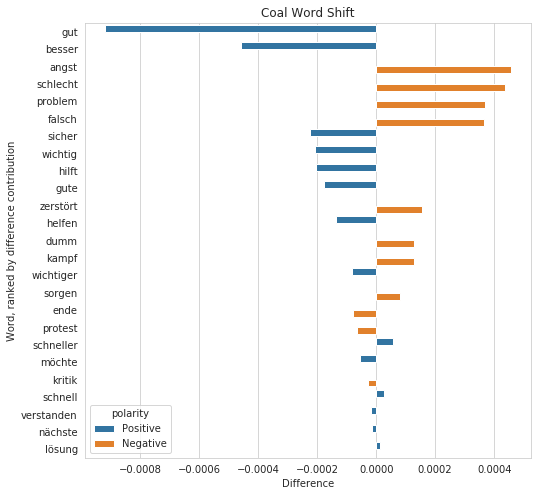

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(y='word',
            x='difference_norm',
            hue='polarity',
            data=df_wordshift,
            ax = ax
           )

ax.set(xlabel="Difference",
       ylabel="Word, ranked by difference contribution", 
       title="Coal Word Shift")

plt.show()
#fig.savefig('plots/wordshift_coal_climate.png', dpi=300, bbox_inches='tight')

In [47]:
print(len(tweets_before_tm), len(tweets_after_tm))

776951 224246


In [48]:
tweets_before['period'] = "climate"
tweets_after['period'] = "coal"

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
tweets_combined = pd.concat([tweets_before, tweets_after], ignore_index=True, sort=False)

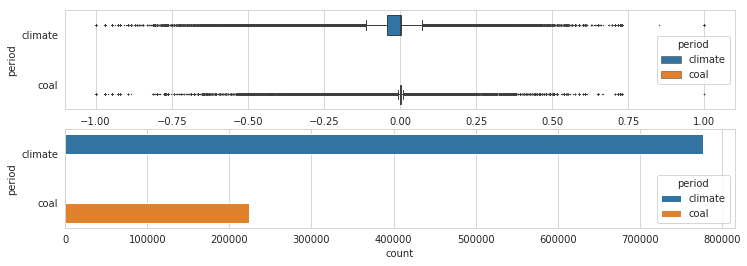

In [50]:
fig, ax = plt.subplots(2,figsize=(12,4))

sns.countplot(y='period', hue='period', data=tweets_combined, ax=ax[1])

sns.boxplot(y='period', x='score', hue='period', data=tweets_combined,
           fliersize=0.5, linewidth=1,
           ax=ax[0]
           )

plt.show()
#fig.savefig('plots/wordshift_coal_climate_stats.png', dpi=300, bbox_inches='tight')

In [51]:
# removing the 0s from tweet statistics
tweets_combined_nz = tweets_combined[tweets_combined['score'] != 0]
print(len(tweets_combined), len(tweets_combined_nz))

1001197 687897


In [52]:
tweets_combined_nz.head()

,id,created_at,text,lang,score,date_only,period
1,1138064056315764736,2019-06-10 12:43:09+00:00,@Der_KaiErik Könnte mir Schlimmeres vorstellen...,de,0.37160,2019-06-10,climate
3,968141946152718337,2018-02-26 15:13:21+00:00,"""Es ist doch so kalt gerade, gibt es die Erder...",de,0.03515,2018-02-26,climate
4,847060213677084673,2017-03-29 12:17:47+00:00,@dieLinke Das Klima reguliert sich selber seit...,de,-0.59010,2017-03-29,climate
8,1062754647952252930,2018-11-14 17:10:27+00:00,Wessen Interessen werden lokale Akteure und di...,de,0.00400,2018-11-14,climate
11,1069671473705570304,2018-12-03 19:15:27+00:00,@Oliver_Krischer @energieexperten Laschet mach...,de,-0.16830,2018-12-03,climate


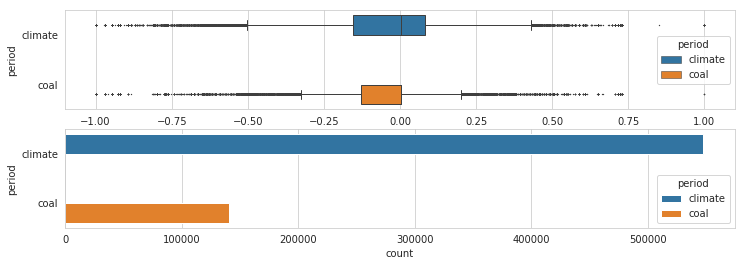

In [53]:
fig, ax = plt.subplots(2,figsize=(12,4))

sns.countplot(y='period', hue='period', data=tweets_combined_nz, ax=ax[1])

sns.boxplot(y='period', x='score', hue='period', data=tweets_combined_nz,
           fliersize=0.5, linewidth=1,
           ax=ax[0]
           )

plt.show()
#fig.savefig('plots/wordshift_coal_climate_stats_nonzero.png', dpi=300, bbox_inches='tight')

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


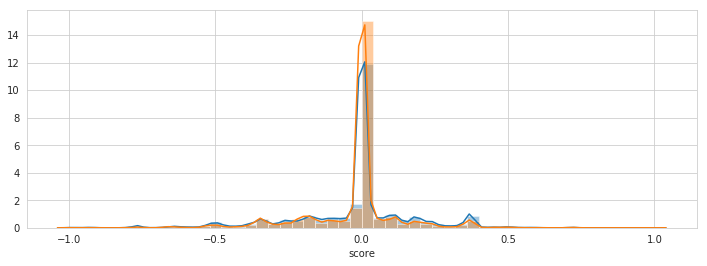

In [61]:
# log hist
fig, ax = plt.subplots(figsize=(12,4))

sns.distplot(tweets_before['score'],
           #fliersize=0.5, linewidth=1,
           #ax=ax[0]
             #hist_kws={"log": "True"}
           )

sns.distplot(tweets_after['score'],
             #hist_kws={"log": "True"}
           )

plt.show()

In [64]:
tweets_before_nz = tweets_before[tweets_before['score'] != 0]
tweets_after_nz = tweets_after[tweets_after['score'] != 0]

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


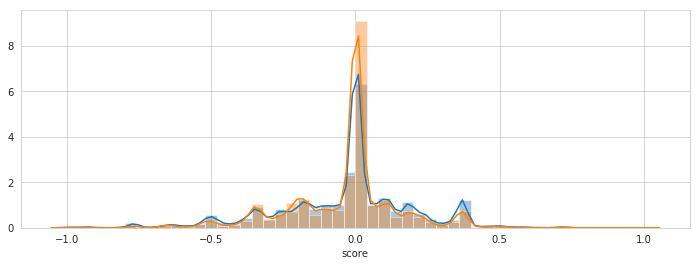

In [70]:
# removing the 0s from tweet statistics
fig, ax = plt.subplots(figsize=(12,4))

sns.distplot(tweets_before_nz['score'],
           #fliersize=0.5, linewidth=1,
           #ax=ax[0]
             #hist_kws={"log": "True"}
           )

sns.distplot(tweets_after_nz['score'],
             #hist_kws={"log": "True"}
           )

plt.show()

In [95]:
# list of words to look for 
top_wordshift = list(df_wordshift['word'])

In [250]:
def get_word_score(word):
    doc = nlp(word)
    for token in doc:
        score = token._.sentiws 
    return score

In [252]:
top_ws_score = [get_word_score(word) for word in top_wordshift]

In [266]:
def get_polarity(score):
    if score > 0:
        word_polarity = "Positive"
    elif score < 0:
        word_polarity = "Negative"
    return word_polarity

In [268]:
top_ws_pol = [get_polarity(score) for score in top_ws_score]

In [269]:
zippedList =  list(zip(top_wordshift, top_ws_score, top_ws_pol))
df_topws = pd.DataFrame(zippedList, columns = ['word' , 'score', 'polarity']) 

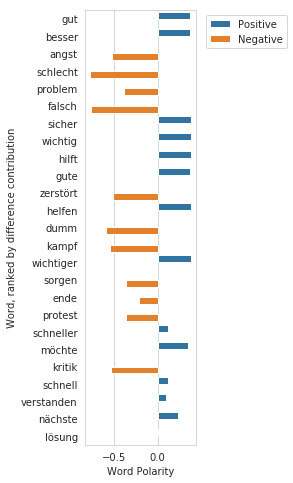

In [272]:
fig, ax = plt.subplots(figsize=(2,8))
sns.barplot(y='word',
            x='score',
            hue='polarity',
            data=df_topws,
            ax = ax
           )

ax.set(xlabel="Word Polarity",
       ylabel="Word, ranked by difference contribution"
      )
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [ ]:
# create a count of each word over time 

In [96]:
top_wordshift

['gut',
 'besser',
 'angst',
 'schlecht',
 'problem',
 'falsch',
 'sicher',
 'wichtig',
 'hilft',
 'gute',
 'zerstört',
 'helfen',
 'dumm',
 'kampf',
 'wichtiger',
 'sorgen',
 'ende',
 'protest',
 'schneller',
 'möchte',
 'kritik',
 'schnell',
 'verstanden',
 'nächste',
 'lösung']

In [63]:
import string

In [83]:
def word_counter(tweet, word):
    """counts the number of times a word appears in a sentence"""
    table = str.maketrans('', '', string.punctuation)
    try:
        str_punc = tweet.translate(table)
        str_split = str_punc.lower().split()
        count = str_split.count(word)
    except:
        count = 0
        pass
    return count

In [65]:
test_string = texts_de.loc[0]['text']
test_string

'Die USA bremsen #Klimaabkommen, weil sie noch stark auf #Kohle setzen. Aber der Widerstand vor Ort wächst: http://bit.ly/7tRFNd'

In [72]:
table = str.maketrans('', '', string.punctuation)    
str_punc = test_string.translate(table)
str_split = str_punc.lower().split()
str_split

['die',
 'usa',
 'bremsen',
 'klimaabkommen',
 'weil',
 'sie',
 'noch',
 'stark',
 'auf',
 'kohle',
 'setzen',
 'aber',
 'der',
 'widerstand',
 'vor',
 'ort',
 'wächst',
 'httpbitly7trfnd']

In [76]:
word_counter(test_string, "kohle")

1

In [74]:
# test on sample
texts_de_test = texts_de.iloc[:100]

gut_counter = []
for i in texts_de_test.index:
    entry = texts_de_test.loc[i]
    
    gut_count = word_counter(entry['text'],"gut")
    
    gut_counter.append(gut_count)

In [84]:
# gut
gut_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    gut_count = word_counter(entry['text'],"gut")
    gut_counter.append(gut_count)

In [89]:
# besser
besser_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    besser_count = word_counter(entry['text'],"besser")
    besser_counter.append(besser_count)

In [90]:
# angst
angst_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    angst_count = word_counter(entry['text'],"angst")
    angst_counter.append(angst_count)

In [91]:
# schlecht
schlecht_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    schlecht_count = word_counter(entry['text'],"schlecht")
    schlecht_counter.append(schlecht_count)

In [92]:
# problem
problem_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    problem_count = word_counter(entry['text'],"problem")
    problem_counter.append(problem_count)

In [93]:
# falsch
falsch_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    falsch_count = word_counter(entry['text'],"falsch")
    falsch_counter.append(falsch_count)

In [94]:
# sicher
sicher_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    sicher_count = word_counter(entry['text'],"sicher")
    sicher_counter.append(sicher_count)

In [95]:
# wichtig
wichtig_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    wichtig_count = word_counter(entry['text'],"wichtig")
    wichtig_counter.append(wichtig_count)

In [96]:
# hilft
hilft_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    hilft_count = word_counter(entry['text'],"hilft")
    hilft_counter.append(hilft_count)

In [97]:
# gute
gute_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    gute_count = word_counter(entry['text'],"gute")
    gute_counter.append(gute_count)

In [98]:
# zestört
zestört_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    zestört_count = word_counter(entry['text'],"zestört")
    zestört_counter.append(zestört_count)

In [99]:
# helfen
helfen_counter = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    helfen_count = word_counter(entry['text'],"helfen")
    helfen_counter.append(helfen_count)

In [100]:
coal_word_count =  list(zip(gut_counter, besser_counter, angst_counter, schlecht_counter, problem_counter, falsch_counter, 
                            sicher_counter, wichtig_counter, hilft_counter, gute_counter, zestört_counter, helfen_counter))
df_coal_word_count = pd.DataFrame(coal_word_count, columns = ['gut' , 'besser', 'angst', 'schlecht', 'problem', 'falsch',
                                                              'sicher', 'wichtig', 'hilft', 'gute', 'zestört', 'helfen']) 
df_coal_word_count.to_csv('df_coal_word_count.csv')

In [101]:
df_coal_word_count.head()

,gut,besser,angst,schlecht,problem,falsch,sicher,wichtig,hilft,gute,zestört,helfen
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
texts_de_word_count = pd.concat([texts_de, df_coal_word_count], axis=1)
texts_de_word_count.head()

,id,created_at,text,lang,score,date_only,gut,besser,angst,schlecht,problem,falsch,sicher,wichtig,hilft,gute,zestört,helfen
0,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.004000,2009-11-22,0,0,0,0,0,0,0,0,0,0,0,0
1,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.340800,2009-11-23,0,0,0,0,0,0,0,0,0,0,0,0
2,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.086533,2009-11-26,0,1,0,0,0,0,0,0,1,0,0,0
3,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01,0,0,0,0,0,0,0,0,0,0,0,0
4,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02,0,0,0,0,0,0,0,0,0,0,0,0


In [127]:
# summing those with the same root words
gut2 = texts_de_word_count['gut'] + texts_de_word_count['gute']
helf2 = texts_de_word_count['hilft'] + texts_de_word_count['helfen']

texts_de_word_count['gut2'] = gut2
texts_de_word_count['helf2'] = helf2

In [114]:
words_list = ['gut' , 'besser', 'angst', 'schlecht', 'problem', 'falsch', 
              'sicher', 'wichtig', 'hilft', 'gute', 'zestört', 'helfen']

gut_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['gut'].sum()
besser_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['besser'].sum()
angst_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['angst'].sum()
schlecht_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['schlecht'].sum()
problem_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['problem'].sum()
falsch_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['falsch'].sum()
sicher_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['sicher'].sum()
wichtig_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['wichtig'].sum()
hilft_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['hilft'].sum()
gute_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['gute'].sum()
zestört_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['zestört'].sum()
helfen_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['helfen'].sum()

In [128]:
gut2_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['gut2'].sum()
helf2_sum_daily = texts_de_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['helf2'].sum()

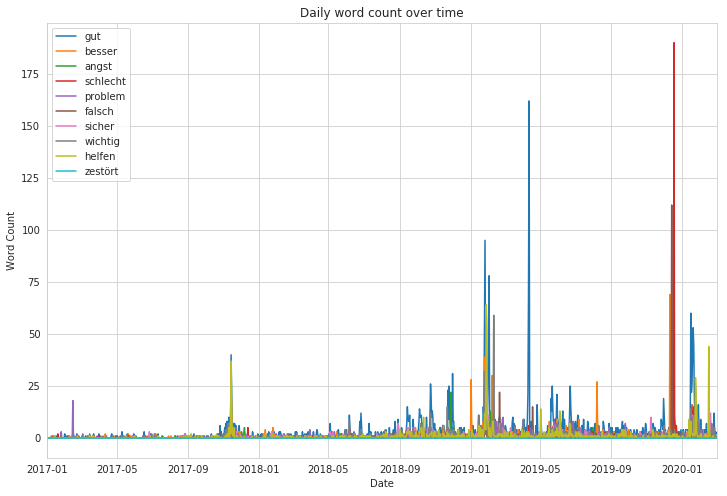

In [132]:
# plot trend
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(gut2_sum_daily.index, gut2_sum_daily, label='gut',ax = ax)
#sns.lineplot(gut_sum_daily.index, gut_sum_daily, label='gut',ax = ax)
sns.lineplot(besser_sum_daily.index, besser_sum_daily, label='besser',ax = ax)
sns.lineplot(angst_sum_daily.index, angst_sum_daily, label='angst',ax = ax)
sns.lineplot(schlecht_sum_daily.index, schlecht_sum_daily, label='schlecht',ax = ax)
sns.lineplot(problem_sum_daily.index, problem_sum_daily, label='problem',ax = ax)
sns.lineplot(falsch_sum_daily.index, falsch_sum_daily, label='falsch',ax = ax)
sns.lineplot(sicher_sum_daily.index, sicher_sum_daily, label='sicher',ax = ax)
sns.lineplot(wichtig_sum_daily.index, wichtig_sum_daily, label='wichtig',ax = ax)
sns.lineplot(helf2_sum_daily.index, helf2_sum_daily, label='helfen',ax = ax)
#sns.lineplot(hilft_sum_daily.index, hilft_sum_daily, label='hilft',ax = ax)
#sns.lineplot(gute_sum_daily.index, gute_sum_daily, label='gute',ax = ax)
sns.lineplot(zestört_sum_daily.index, zestört_sum_daily, label='zestört',ax = ax)
#sns.lineplot(helfen_sum_daily.index, helfen_sum_daily, label='helfen',ax = ax)


ax.set(xlim=(datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'), 
             datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')),
       xlabel="Date",
       ylabel="Word Count", 
       title="Daily word count over time")


plt.show()
fig.savefig('plots/wordshift_topword_freq.png', dpi=300, bbox_inches='tight')

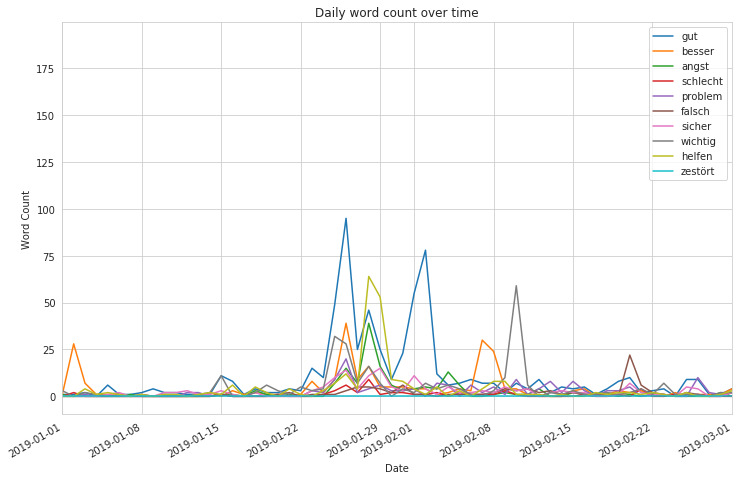

In [133]:
# release of report
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(gut2_sum_daily.index, gut2_sum_daily, label='gut',ax = ax)
#sns.lineplot(gut_sum_daily.index, gut_sum_daily, label='gut',ax = ax)
sns.lineplot(besser_sum_daily.index, besser_sum_daily, label='besser',ax = ax)
sns.lineplot(angst_sum_daily.index, angst_sum_daily, label='angst',ax = ax)
sns.lineplot(schlecht_sum_daily.index, schlecht_sum_daily, label='schlecht',ax = ax)
sns.lineplot(problem_sum_daily.index, problem_sum_daily, label='problem',ax = ax)
sns.lineplot(falsch_sum_daily.index, falsch_sum_daily, label='falsch',ax = ax)
sns.lineplot(sicher_sum_daily.index, sicher_sum_daily, label='sicher',ax = ax)
sns.lineplot(wichtig_sum_daily.index, wichtig_sum_daily, label='wichtig',ax = ax)
sns.lineplot(helf2_sum_daily.index, helf2_sum_daily, label='helfen',ax = ax)
#sns.lineplot(hilft_sum_daily.index, hilft_sum_daily, label='hilft',ax = ax)
#sns.lineplot(gute_sum_daily.index, gute_sum_daily, label='gute',ax = ax)
sns.lineplot(zestört_sum_daily.index, zestört_sum_daily, label='zestört',ax = ax)
#sns.lineplot(helfen_sum_daily.index, helfen_sum_daily, label='helfen',ax = ax)

ax.set(xlim=(datetime.datetime.strptime('2019-01-01', '%Y-%m-%d'), 
             datetime.datetime.strptime('2019-03-01', '%Y-%m-%d')),
       xlabel="Date",
       ylabel="Word Count", 
       title="Daily word count over time")

fig.autofmt_xdate()
plt.show()
fig.savefig('plots/wordshift_topword_freq_zoom.png', dpi=300, bbox_inches='tight')

In [119]:
# repeat for climate
# gut
gut_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    gut_count = word_counter(entry['text'],"gut")
    gut_counter2.append(gut_count)

# besser
besser_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    besser_count = word_counter(entry['text'],"besser")
    besser_counter2.append(besser_count)

# angst
angst_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    angst_count = word_counter(entry['text'],"angst")
    angst_counter2.append(angst_count)

# schlecht
schlecht_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    schlecht_count = word_counter(entry['text'],"schlecht")
    schlecht_counter2.append(schlecht_count)

# problem
problem_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    problem_count = word_counter(entry['text'],"problem")
    problem_counter2.append(problem_count)

# falsch
falsch_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    falsch_count = word_counter(entry['text'],"falsch")
    falsch_counter2.append(falsch_count)

# sicher
sicher_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    sicher_count = word_counter(entry['text'],"sicher")
    sicher_counter2.append(sicher_count)

NameError: name 'wichtig_counter2' is not defined

In [122]:
# wichtig
wichtig_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    wichtig_count = word_counter(entry['text'],"wichtig")
    wichtig_counter2.append(wichtig_count)

# hilft
hilft_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    hilft_count = word_counter(entry['text'],"hilft")
    hilft_counter2.append(hilft_count)

# gute
gute_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    gute_count = word_counter(entry['text'],"gute")
    gute_counter2.append(gute_count)

# zestört
zestört_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    zestört_count = word_counter(entry['text'],"zestört")
    zestört_counter2.append(zestört_count)
    
# helfen
helfen_counter2 = []
for i in texts_climate.index:
    entry = texts_climate.loc[i]
    helfen_count = word_counter(entry['text'],"helfen")
    helfen_counter2.append(helfen_count)

In [123]:
climate_word_count =  list(zip(gut_counter2, besser_counter2, angst_counter2, schlecht_counter2, problem_counter2, falsch_counter2, 
                            sicher_counter2, wichtig_counter2, hilft_counter2, gute_counter2, zestört_counter2, helfen_counter2))
df_climate_word_count = pd.DataFrame(climate_word_count, columns = ['gut' , 'besser', 'angst', 'schlecht', 'problem', 'falsch',
                                                              'sicher', 'wichtig', 'hilft', 'gute', 'zestört', 'helfen']) 
df_climate_word_count.to_csv('df_climate_word_count.csv')

In [124]:
texts_climate_word_count = pd.concat([texts_climate, df_climate_word_count], axis=1)

In [125]:
gut_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['gut'].sum()
besser_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['besser'].sum()
angst_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['angst'].sum()
schlecht_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['schlecht'].sum()
problem_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['problem'].sum()
falsch_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['falsch'].sum()
sicher_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['sicher'].sum()
wichtig_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['wichtig'].sum()
hilft_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['hilft'].sum()
gute_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['gute'].sum()
zestört_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['zestört'].sum()
helfen_sum_daily2 = texts_climate_word_count.groupby(pd.Grouper(key='date_only',freq='D'))['helfen'].sum()

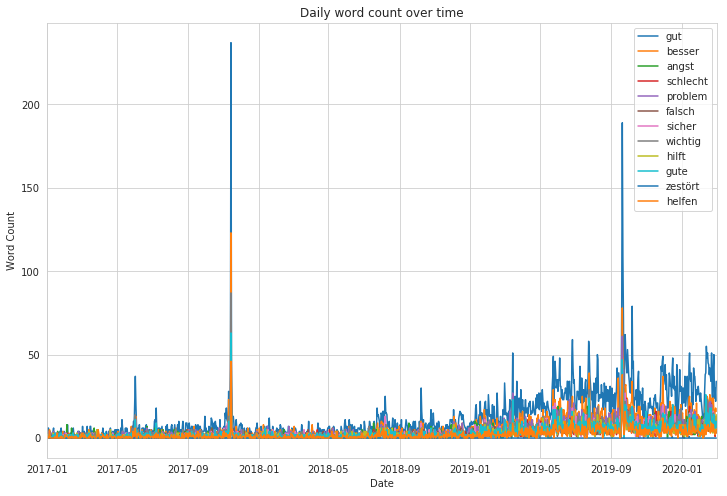

In [126]:
# plot trend
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(gut_sum_daily2.index, gut_sum_daily2, label='gut',ax = ax)
sns.lineplot(besser_sum_daily2.index, besser_sum_daily2, label='besser',ax = ax)
sns.lineplot(angst_sum_daily2.index, angst_sum_daily2, label='angst',ax = ax)
sns.lineplot(schlecht_sum_daily2.index, schlecht_sum_daily2, label='schlecht',ax = ax)
sns.lineplot(problem_sum_daily2.index, problem_sum_daily2, label='problem',ax = ax)
sns.lineplot(falsch_sum_daily2.index, falsch_sum_daily2, label='falsch',ax = ax)
sns.lineplot(sicher_sum_daily2.index, sicher_sum_daily2, label='sicher',ax = ax)
sns.lineplot(wichtig_sum_daily2.index, wichtig_sum_daily2, label='wichtig',ax = ax)
sns.lineplot(hilft_sum_daily2.index, hilft_sum_daily2, label='hilft',ax = ax)
sns.lineplot(gute_sum_daily2.index, gute_sum_daily2, label='gute',ax = ax)
sns.lineplot(zestört_sum_daily2.index, zestört_sum_daily2, label='zestört',ax = ax)
sns.lineplot(helfen_sum_daily2.index, helfen_sum_daily2, label='helfen',ax = ax)


ax.set(xlim=(datetime.datetime.strptime('2017-01-01', '%Y-%m-%d'), 
             datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')),
       xlabel="Date",
       ylabel="Word Count", 
       title="Daily word count over time")


plt.show()